In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
import dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary

In [70]:
delays_df = dmba.load_data('FlightDelays.csv')
delays_df = delays_df.drop(columns=['DEP_TIME'])

delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')
delays_df['Flight Status'] = delays_df['Flight Status'].astype('category')

delays_df.CRS_DEP_TIME = [round(t / 180) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['CRS_DEP_TIME', 'CARRIER', 'DEST', 'DISTANCE', 'FL_DATE', 'FL_NUM', 
              'ORIGIN', 'DAY_WEEK', 'DAY_OF_MONTH', 'TAIL_NUM']
outcome = 'Flight Status'

X = pd.get_dummies(delays_df[predictors], drop_first=True)
y = delays_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)


delays_df


,CRS_DEP_TIME,CARRIER,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,8,OH,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,9,DH,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,7,DH,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,10,DH,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,6,DH,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime
...,...,...,...,...,...,...,...,...,...,...,...,...
2196,4,RU,EWR,199,1/31/2004,2761,DCA,0,6,31,N15555,ontime
2197,9,RU,EWR,213,1/31/2004,2497,IAD,0,6,31,N16976,ontime
2198,9,RU,EWR,199,1/31/2004,2361,DCA,0,6,31,N14902,ontime
2199,8,RU,EWR,199,1/31/2004,2216,DCA,0,6,31,N16961,ontime


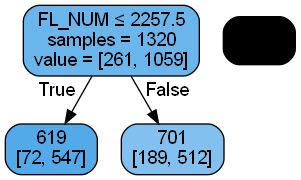

In [71]:
fullClassTree = DecisionTreeClassifier(max_depth=8, min_samples_split=20,  min_impurity_decrease=0.01)
fullClassTree.fit(train_X, train_y)

plotDecisionTree(fullClassTree, feature_names=train_X.columns)


In [72]:
classificationSummary(train_y, fullClassTree.predict(train_X))
classificationSummary(valid_y, fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8023)

       Prediction
Actual    0    1
     0    0  261
     1    0 1059
Confusion Matrix (Accuracy 0.8104)

       Prediction
Actual   0   1
     0   0 167
     1   0 714


In [73]:
# Five-fold cross-validation of the full decision tree classifier
treeClassifier = DecisionTreeClassifier()

scores = cross_val_score(treeClassifier, train_X, train_y, cv=5)
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in scores])
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})')
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})')

Accuracy scores of each fold:  ['0.792', '0.746', '0.795', '0.723', '0.777']
Accuracy: 0.767 (+/- 0.055)
Accuracy: 0.767 (+/- 0.028)


In [74]:
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2, 16)), 
    'min_samples_split': list(range(10, 22)), 
    'min_impurity_decrease': [0.0009, 0.001, 0.0011], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

Initial score:  0.8030303030303031
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 100}
Improved score:  0.8060606060606063
Improved parameters:  {'max_depth': 6, 'min_impurity_decrease': 0.001, 'min_samples_split': 20}


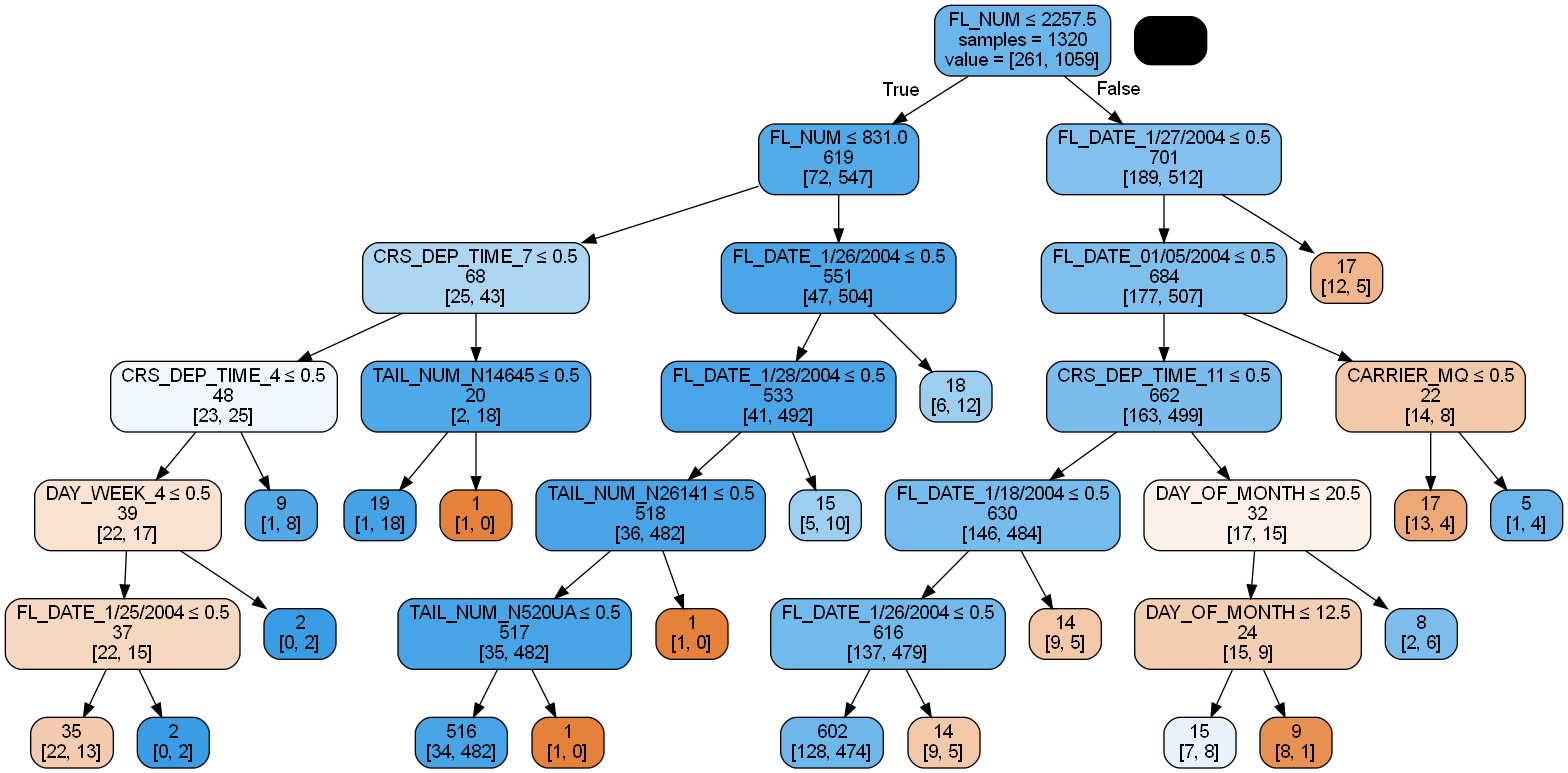

In [75]:
plotDecisionTree(bestClassTree, feature_names=train_X.columns)

In [76]:
classificationSummary(train_y, bestClassTree.predict(train_X))
classificationSummary(valid_y, bestClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8348)

       Prediction
Actual    0    1
     0   76  185
     1   33 1026
Confusion Matrix (Accuracy 0.8229)

       Prediction
Actual   0   1
     0  47 120
     1  36 678
